<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implémentez-un-modèle-de-scoring" data-toc-modified-id="Implémentez-un-modèle-de-scoring-1"><strong>Implémentez un modèle de scoring</strong></a></span></li><li><span><a href="#0.-Imports-and-fonctions" data-toc-modified-id="0.-Imports-and-fonctions-2">0. Imports and fonctions</a></span></li><li><span><a href="#1.-Les-données" data-toc-modified-id="1.-Les-données-3">1. Les données</a></span></li><li><span><a href="#2.-Sélection-des-features" data-toc-modified-id="2.-Sélection-des-features-4">2. Sélection des features</a></span></li><li><span><a href="#3.-Analyse-exploratoire-des-données" data-toc-modified-id="3.-Analyse-exploratoire-des-données-5">3. Analyse exploratoire des données</a></span><ul class="toc-item"><li><span><a href="#3.1-Distributions-des-variables" data-toc-modified-id="3.1-Distributions-des-variables-5.1">3.1 Distributions des variables</a></span></li><li><span><a href="#3.2-Corrélations" data-toc-modified-id="3.2-Corrélations-5.2">3.2 Corrélations</a></span></li><li><span><a href="#3.3-Valeurs-aberrantes" data-toc-modified-id="3.3-Valeurs-aberrantes-5.3">3.3 Valeurs aberrantes</a></span><ul class="toc-item"><li><span><a href="#Variables-de-1-à-10" data-toc-modified-id="Variables-de-1-à-10-5.3.1">Variables de 1 à 10</a></span></li><li><span><a href="#Variables-de-11-à-20" data-toc-modified-id="Variables-de-11-à-20-5.3.2">Variables de 11 à 20</a></span></li><li><span><a href="#Variables-de-21-à-30" data-toc-modified-id="Variables-de-21-à-30-5.3.3">Variables de 21 à 30</a></span></li><li><span><a href="#Variables-de-31-à-40" data-toc-modified-id="Variables-de-31-à-40-5.3.4">Variables de 31 à 40</a></span></li><li><span><a href="#Variables-de-41-à-50" data-toc-modified-id="Variables-de-41-à-50-5.3.5">Variables de 41 à 50</a></span></li><li><span><a href="#Variables-de-51-à-60" data-toc-modified-id="Variables-de-51-à-60-5.3.6">Variables de 51 à 60</a></span></li><li><span><a href="#Variables-de-61-à-70" data-toc-modified-id="Variables-de-61-à-70-5.3.7">Variables de 61 à 70</a></span></li><li><span><a href="#Variables-de-71-à-80" data-toc-modified-id="Variables-de-71-à-80-5.3.8">Variables de 71 à 80</a></span></li><li><span><a href="#Variables-de-81-à-90" data-toc-modified-id="Variables-de-81-à-90-5.3.9">Variables de 81 à 90</a></span></li><li><span><a href="#Variables-de-91-à-94" data-toc-modified-id="Variables-de-91-à-94-5.3.10">Variables de 91 à 94</a></span></li></ul></li></ul></li><li><span><a href="#4.-Conclusions" data-toc-modified-id="4.-Conclusions-6">4. Conclusions</a></span></li></ul></div>

# **Implémentez un modèle de scoring**

La société financière "Prêt à dépenser" propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser a décidé donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

Mon objectif est donc:
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
- Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.


Pour faciliter l’analyse exploratoire, la préparation des données et le feature engineering nécessaires à l’élaboration du modèle de scoring j'ai utilise un kernel Kaggle, disponible sur https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script. 

Ce notebook est consacré au nettoyage et à l'analyse exploratoire des données. Les modélisations sont disponible dans le notebook **modelisations.ipynb**.

# 0. Imports and fonctions

In [1]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Function to list features that are correlated
# Adapted from https://openclassrooms.com/fr/courses/6401081-improve-the-performance-of-a-machine-learning-model/6539936-improve-your-feature-selection
def correlatedFeatures(dataset, threshold):
    """
    Args:
    dataset: dataframe
    threshold: threshold value for correlation
    Return:
    list of tuples of correlated columns
    """
    correlated_columns = []
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i, j]) > threshold:
                correlated_columns.append((
                    correlations.columns[i],
                    correlations.columns[j]))
    return correlated_columns

In [3]:
# Function to replace outliers
def replace_outliers(data, columns, high_or_low):
    """
    Args:
    data: dataframe
    columns: list of columns where to replace the outliers
    high_or_low: string. If 'high': all values > 0.9 quantile
    will be replaced with the value of the 0.9 quantile.
    If 'low': all values < 0.1 quantile will be replaced
    with the value of the 0.1 quantile
    Return:
    dataframe with replaced outliers
    """
    if high_or_low == 'high':
        for column in columns:
            data.loc[data[column] > data[column].quantile(0.9),
                     column] = data[column].quantile(0.9)
    if high_or_low == 'low':
        for column in columns:
            data.loc[data[column] < data[column].quantile(0.1),
                     column] = data[column].quantile(0.1)
    return data

In [4]:
# matplotlib parameters
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11

# 1. Les données

Dans cette partie je vais examiner rapidement le jeu de données, déjà prétraité avec le kernel Kaggle, pour avoir des information de base (taille, type de donnés, nombre de clients qui ont remboursé le crédit et valeurs manquantes) et je vais réaliser des prétraitements pour nettoyer le jeu de données.

In [5]:
# reading the data
data = pd.read_csv('../Kernel_preprocessing.csv')

In [6]:
# data samples
data.sample(5)

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
40083,40085,40085,146433,0.0,0,1,0,1,180000.0,269550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253582,253586,253586,393433,0.0,0,1,1,1,247500.0,540000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65619,65621,65621,176106,1.0,1,1,0,1,123750.0,545040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11283,11283,11283,113144,0.0,0,0,0,1,202500.0,254700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16336,16336,16336,119052,0.0,1,0,0,0,108000.0,254700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# dataframe shape
data.shape

(356251, 799)

In [8]:
# missing values count
data.isna().sum()

Unnamed: 0                               0
index                                    0
SK_ID_CURR                               0
TARGET                               48744
CODE_GENDER                              0
                                     ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     252693
CC_NAME_CONTRACT_STATUS_nan_MEAN    252693
CC_NAME_CONTRACT_STATUS_nan_SUM     252693
CC_NAME_CONTRACT_STATUS_nan_VAR     253385
CC_COUNT                            252693
Length: 799, dtype: int64

La variable qu'il faut predire, `TARGET`, a de valeurs manquantes. Il s'agit des observations du jeu de données de test fourni par Kaggle, pour lequelles je vais créer un dataframe et un fichier à part.

In [9]:
# saving Kaggle test data
test_kaggle = data.loc[data['TARGET'].isna()]
test_kaggle.to_csv('../test_kaggle.csv')

In [10]:
# select data with non null TARGET
data = data.loc[data['TARGET'].notna()]

In [11]:
# count TARGET values
data['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

Text(0, 0.5, "Nombre d'observations")

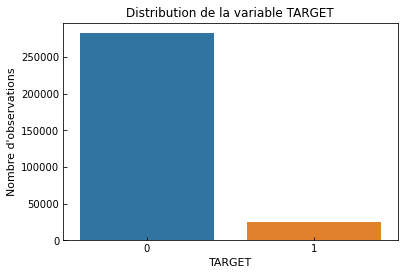

In [39]:
# plot TARGET values
sns.barplot(x=[0, 1], y=data['TARGET'].value_counts())
plt.title('Distribution de la variable TARGET')
plt.xlabel('TARGET')
plt.ylabel('Nombre d\'observations')

La valeur 1 de la variable TARGET correspond aux clients qui ont fait défaut, la valeur 0 aux clients qui ont remboursé leur crédit. On peut bien voir que les classes sont déséquilibrées: le nombre de clients qui ont remboursé est à peu près 11 fois le nombre de clients qui n'ont pas remboursé.

In [12]:
# suppression of 'Unnamed: 0' variable and reindexing
data = data.drop(['Unnamed: 0', 'index'], axis=1)
data = data.set_index('SK_ID_CURR')
test_kaggle = test_kaggle.drop(['Unnamed: 0', 'index'], axis=1)
test_kaggle = test_kaggle.set_index('SK_ID_CURR')

Je vais supprimer le variables avec plus de 80% de valeurs manquantes

In [13]:
# suppression of features with too many null values
data = data.loc[:, data.isna().sum() < data.shape[0]*0.2]
test_kaggle = test_kaggle[data.columns]

In [14]:
# replacing inf values with nan
data[data == np.inf] = np.nan
test_kaggle[test_kaggle == np.inf] = np.nan

In [10]:
# count variables types
data.dtypes.value_counts()

float64    333
int64      174
dtype: int64

In [15]:
# example of float64 variables
np.random.choice(data.loc[:, data.dtypes == 'float64'].columns, 10)

array(['PREV_NAME_GOODS_CATEGORY_nan_MEAN',
       'PREV_NAME_PORTFOLIO_POS_MEAN',
       'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN', 'POS_SK_DPD_MEAN',
       'APPROVED_DAYS_DECISION_MEAN',
       'PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN',
       'BURO_CREDIT_TYPE_Mobile operator loan_MEAN',
       'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
       'PREV_NAME_PRODUCT_TYPE_XNA_MEAN',
       'PREV_NAME_SELLER_INDUSTRY_XNA_MEAN'], dtype=object)

In [22]:
# example of int64 variables
np.random.choice(data.loc[:, data.dtypes == 'int64'].columns, 10)

array(['CNT_CHILDREN', 'LIVE_REGION_NOT_WORK_REGION',
       'ORGANIZATION_TYPE_Transport: type 1',
       'OCCUPATION_TYPE_Security staff',
       'WEEKDAY_APPR_PROCESS_START_MONDAY',
       'FONDKAPREMONT_MODE_not specified', 'FLAG_DOCUMENT_10',
       'OCCUPATION_TYPE_Cooking staff', 'ORGANIZATION_TYPE_Security',
       'HOUR_APPR_PROCESS_START'], dtype=object)

En examinant les types des variables, on peut voir que les variables de type `int64` sont dérivées des pré-traitements One Hot Encoding. Pour les variables de type `float64`, je vais remplacer les valeurs manquantes avec la médiane. Pour les variables de type `int64`, je vais les remplacer avec la valeur la plus fréquente.

Avant de remplacer les valeur manquantes, je vais séparer le jeu de données en jeu d'entrainement et test

In [232]:
# split the data in train and test set
train, test = train_test_split(data,
                               stratify=data['TARGET'],
                               train_size=0.8,
                               random_state=17)

In [178]:
# checking train size
train.shape

(246005, 507)

In [179]:
# checking test size
test.shape

(61502, 507)

In [233]:
# replacing null values with median
median_imputer = SimpleImputer(strategy='median')
train[train.select_dtypes('float64').columns] = median_imputer.fit_transform(
    train[train.select_dtypes('float64').columns]
)
test[test.select_dtypes('float64').columns] = median_imputer.transform(
    test[test.select_dtypes('float64').columns]
)
test_kaggle[
    test_kaggle.select_dtypes('float64').columns] = median_imputer.transform(
    test_kaggle[test_kaggle.select_dtypes('float64').columns]
)

In [234]:
# replacing null values with most frequent value
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
train[
    train.select_dtypes('int64').columns
] = most_frequent_imputer.fit_transform(
    train[train.select_dtypes('int64').columns])
test[
    test.select_dtypes('int64').columns
] = most_frequent_imputer.transform(
    test[test.select_dtypes('int64').columns])
test_kaggle[
    test_kaggle.select_dtypes('int64').columns
] = most_frequent_imputer.transform(
    test_kaggle[test_kaggle.select_dtypes('int64').columns])

In [52]:
# checking null values in train set
train.isna().sum().sum()

0

In [43]:
# checking null values in test set
test.isna().sum().sum()

0

In [46]:
# checking null values in Kaggle test set
test_kaggle.isna().sum().sum()

0

In [47]:
# saving Kaggle test set without NaN
test_kaggle.to_csv('../test_kaggle_cleaned.csv')

# 2. Sélection des features

Ici, je vais faire une première sélection des features à l'aide de la fonction de sklearn `VarianceThreshold`. En effet, il est probable que les features caractérisées par une petite variance ne vont pas être importantes pour la prédiction. Avant de effectuer la sélection, je vais faire un scaling des données.

In [98]:
# instanciating VarianceThreshold and fit train set
scaler = MinMaxScaler()
X = pd.DataFrame(
    scaler.fit_transform(train),
    columns=train.columns)
selection = VarianceThreshold(threshold=(0.01))
selection.fit(X)

VarianceThreshold(threshold=0.01)

In [99]:
# list of features with variance > 0.01
selection.get_feature_names_out()

array(['TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8',
       'NAME_CONTRACT_TYPE_Cash loans',
       'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Children',
       'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Spouse, partner',
       'NAME_TYPE_SUITE_Unaccompanied',
       'NAME_INCOME_TYPE_Commercial associate',
       'NAME_INCOME_TYPE_Pen

In [235]:
# filter on features
train = train[list(selection.get_feature_names_out())]
test = test[list(selection.get_feature_names_out())]

In [236]:
# dataframe shape after filter
train.shape

(246005, 198)

Le filtre sur la variance a permis de supprimer à peu près 3/5 des variables: on passe de 507 à 198.

Certaines variables ne sont probablement pas liées à la probabilité de défaut (p.e. le jour et l'heure de la demande de prêt, ou encore les matériaux des murs du logement du client, ou combien de jours avant la demande le client a changé de téléphone). Je vais donc supprimer ces variables.

In [237]:
# features to drop
to_drop = [
    'APPROVED_HOUR_APPR_PROCESS_START_MAX',
    'APPROVED_HOUR_APPR_PROCESS_START_MEAN',
    'APPROVED_HOUR_APPR_PROCESS_START_MIN',
    'DAYS_ID_PUBLISH',
    'DAYS_LAST_PHONE_CHANGE',
    'HOUR_APPR_PROCESS_START',
    'PREV_HOUR_APPR_PROCESS_START_MAX',
    'PREV_HOUR_APPR_PROCESS_START_MEAN',
    'PREV_HOUR_APPR_PROCESS_START_MIN',
    'PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN',
    'PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN',
    'PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN',
    'PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN',
    'PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN',
    'PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN',
    'PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN',
    'WALLSMATERIAL_MODE_Block',
    'WALLSMATERIAL_MODE_Panel',
    'WALLSMATERIAL_MODE_Stone, brick',
    'WALLSMATERIAL_MODE_Wooden',
    'WEEKDAY_APPR_PROCESS_START_FRIDAY',
    'WEEKDAY_APPR_PROCESS_START_MONDAY',
    'WEEKDAY_APPR_PROCESS_START_SATURDAY',
    'WEEKDAY_APPR_PROCESS_START_SUNDAY',
    'WEEKDAY_APPR_PROCESS_START_THURSDAY',
    'WEEKDAY_APPR_PROCESS_START_TUESDAY',
    'WEEKDAY_APPR_PROCESS_START_WEDNESDAY'
]

In [238]:
# features suppression
train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

In [239]:
# checking dataframe size after suppression
train.shape

(246005, 171)

Maintenant, afin de réduire le nombre de variables, je vais examiner les boites à moustaches des toutes les variables (20 à la fois) en fonction du TARGET. Si la boite à moustaches est similaire pour les classes 0 et 1, la variable ne va pas probablement pas avoir un pouvoir discriminant et je vais la supprimer (NB: dans ce notebook, dans un souci de lisibilité, je vais juste présenter les boites à moustaches pour les premières 20 variables).

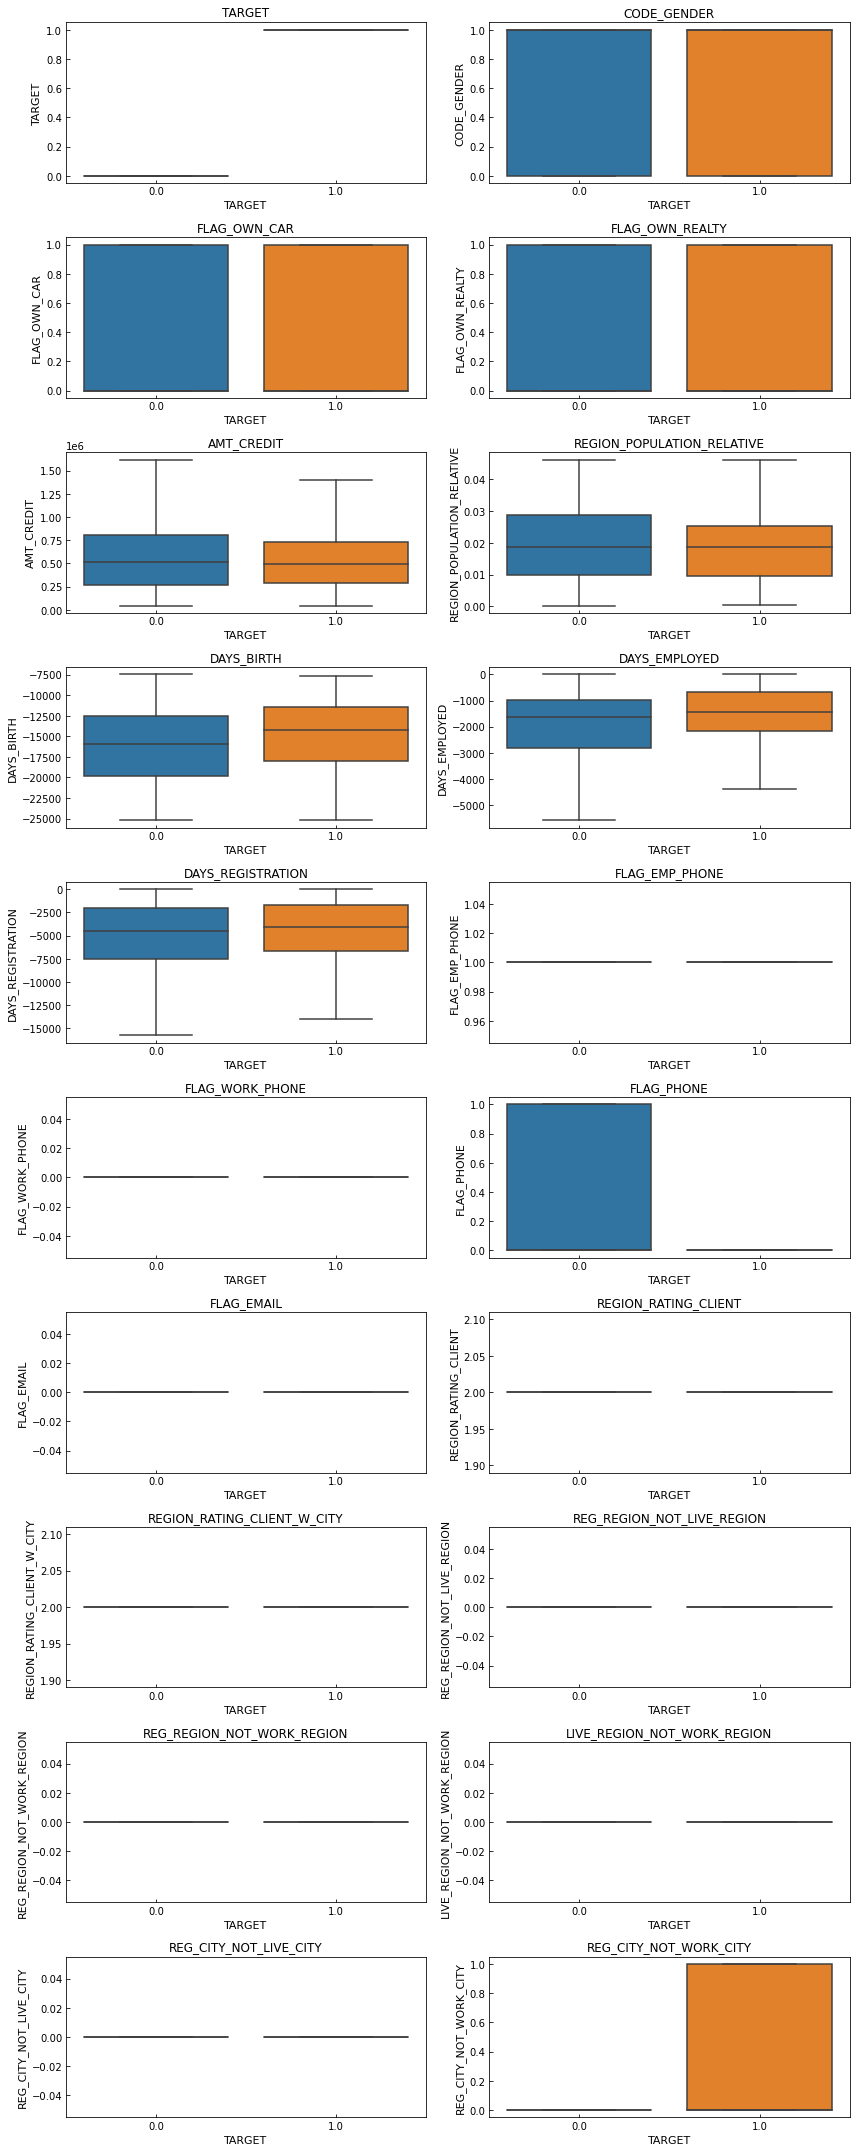

In [240]:
# boxplots
fig, ax = plt.subplots(10, 2, figsize=(12, 30))
count = 1
for col in train.iloc[:, :20].columns:
    plt.subplot(10, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x='TARGET', y=col, showfliers=False)
    count += 1
plt.tight_layout()

Ci-dessous la liste des variables à supprimer.

In [241]:
to_drop = [
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_EMAIL',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY',
    'REG_REGION_NOT_LIVE_REGION',
    'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION',   
    'REG_CITY_NOT_LIVE_CITY',
    'LIVE_CITY_NOT_WORK_CITY',
    'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_8', 'NAME_CONTRACT_TYPE_Cash loans',
    'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Children',
    'NAME_TYPE_SUITE_Family',
    'NAME_TYPE_SUITE_Spouse, partner',
    'NAME_TYPE_SUITE_Unaccompanied',
    'NAME_INCOME_TYPE_Commercial associate',
    'NAME_INCOME_TYPE_Pensioner',
    'NAME_INCOME_TYPE_State servant',
    'NAME_INCOME_TYPE_Working',
    'NAME_EDUCATION_TYPE_Incomplete higher',
    'NAME_EDUCATION_TYPE_Lower secondary',
    'NAME_FAMILY_STATUS_Civil marriage',
    'NAME_FAMILY_STATUS_Married',
    'NAME_FAMILY_STATUS_Separated',
    'NAME_FAMILY_STATUS_Single / not married',
    'NAME_FAMILY_STATUS_Widow',
    'NAME_HOUSING_TYPE_House / apartment',
    'NAME_HOUSING_TYPE_Municipal apartment',
    'NAME_HOUSING_TYPE_Rented apartment',
    'NAME_HOUSING_TYPE_With parents',
    'OCCUPATION_TYPE_Accountants',
    'OCCUPATION_TYPE_Cleaning staff',
    'OCCUPATION_TYPE_Cooking staff',
    'OCCUPATION_TYPE_Core staff',
    'OCCUPATION_TYPE_Drivers',
    'OCCUPATION_TYPE_High skill tech staff',
    'OCCUPATION_TYPE_Laborers',
    'OCCUPATION_TYPE_Managers',
    'OCCUPATION_TYPE_Medicine staff',
    'OCCUPATION_TYPE_Sales staff',
    'OCCUPATION_TYPE_Security staff',
    'ORGANIZATION_TYPE_Business Entity Type 1',
    'ORGANIZATION_TYPE_Business Entity Type 2',
    'ORGANIZATION_TYPE_Construction',
    'ORGANIZATION_TYPE_Government',
    'ORGANIZATION_TYPE_Industry: type 3',
    'ORGANIZATION_TYPE_Industry: type 9',
    'ORGANIZATION_TYPE_Kindergarten',
    'ORGANIZATION_TYPE_Medicine',
    'ORGANIZATION_TYPE_Other',
    'ORGANIZATION_TYPE_School',
    'ORGANIZATION_TYPE_Security',
    'ORGANIZATION_TYPE_Self-employed',
    'ORGANIZATION_TYPE_Trade: type 3',
    'ORGANIZATION_TYPE_Trade: type 7',
    'ORGANIZATION_TYPE_Transport: type 4',
    'ORGANIZATION_TYPE_XNA',
    'FONDKAPREMONT_MODE_not specified',
    'FONDKAPREMONT_MODE_org spec account',
    'FONDKAPREMONT_MODE_reg oper account',
    'FONDKAPREMONT_MODE_reg oper spec account',
    'HOUSETYPE_MODE_block of flats',
    'REG_CITY_NOT_WORK_CITY',
    'EMERGENCYSTATE_MODE_No',
    'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN',
    'PREV_NAME_PAYMENT_TYPE_XNA_MEAN',
    'PREV_CODE_REJECT_REASON_XAP_MEAN',
    'PREV_NAME_TYPE_SUITE_Spouse, partner_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Computers_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN',
    'PREV_CHANNEL_TYPE_AP+ (Cash loan)_MEAN',
    'PREV_CHANNEL_TYPE_Contact center_MEAN',
    'PREV_CHANNEL_TYPE_Regional / Local_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN',
    'PREV_NAME_GOODS_CATEGORY_XNA_MEAN',
    'PREV_NAME_PORTFOLIO_XNA_MEAN',
    'PREV_NAME_PRODUCT_TYPE_XNA_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Construction_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_XNA_MEAN',
    'PREV_NAME_YIELD_GROUP_XNA_MEAN',
    'PREV_NAME_YIELD_GROUP_low_action_MEAN',
    'PREV_PRODUCT_COMBINATION_Cash Street: high_MEAN',
    'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN',
    'PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN',
    'PREV_PRODUCT_COMBINATION_POS household without interest_MEAN',
    'PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN',
    'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN',
    'PREV_PRODUCT_COMBINATION_POS other with interest_MEAN'    
]

In [242]:
# features suppression
train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

In [243]:
# checking dataframe size after suppression
train.shape

(246005, 70)

A l'aide de la fonction `correlatedFeatures` ja vais identifier les couples de variables très corrélées pour en éliminer une de deux (si la corrélation semble être logique).

In [244]:
# finding correlated features
correlated_features = correlatedFeatures(train, 0.9)

In [245]:
# couples of correlated features
correlated_features

[('DAYS_EMPLOYED_PERC', 'DAYS_EMPLOYED'),
 ('BURO_CREDIT_ACTIVE_Closed_MEAN', 'BURO_CREDIT_ACTIVE_Active_MEAN'),
 ('PREV_NAME_PORTFOLIO_Cards_MEAN',
  'PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN'),
 ('PREV_NAME_PORTFOLIO_POS_MEAN',
  'PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN'),
 ('APPROVED_RATE_DOWN_PAYMENT_MAX', 'PREV_RATE_DOWN_PAYMENT_MAX'),
 ('APPROVED_DAYS_DECISION_MIN', 'PREV_DAYS_DECISION_MIN'),
 ('APPROVED_DAYS_DECISION_MEAN', 'PREV_DAYS_DECISION_MEAN'),
 ('INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'POS_MONTHS_BALANCE_MEAN')]

In [246]:
# correlated features to drop
correlated_to_drop = [
    'DAYS_EMPLOYED_PERC', 
    'BURO_CREDIT_ACTIVE_Closed_MEAN',
    'PREV_RATE_DOWN_PAYMENT_MAX',
    'PREV_DAYS_DECISION_MEAN',
    'PREV_DAYS_DECISION_MIN'
]

In [247]:
# suppressing correlated features
train.drop(correlated_to_drop, axis=1, inplace=True)
test.drop(correlated_to_drop, axis=1, inplace=True)

In [248]:
# checking dataframe size after suppression
train.shape

(246005, 65)

# 3. Analyse exploratoire des données

Dans cette partie je vais examiner la distribution des variables, leurs corrélations et les valeurs aberrantes.

## 3.1 Distributions des variables

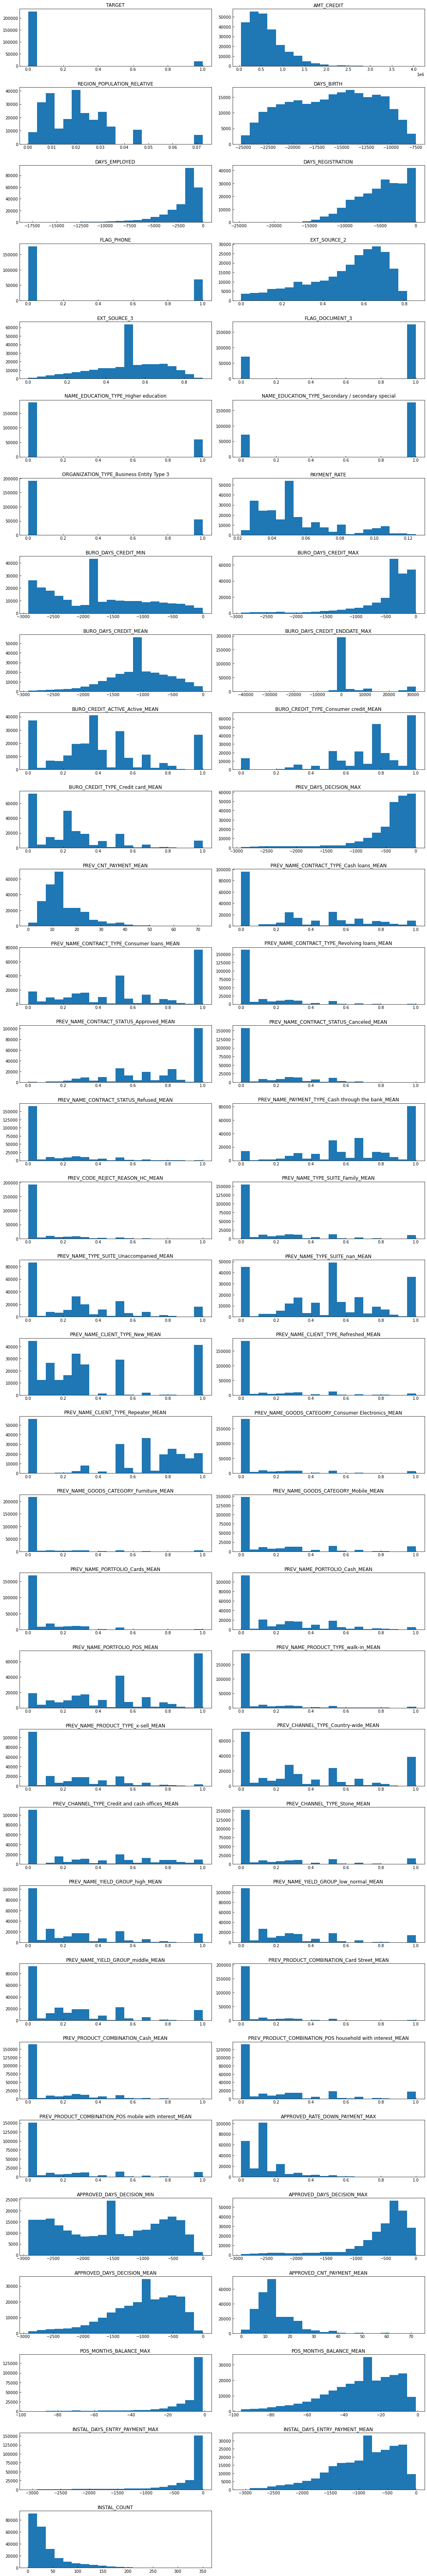

In [250]:
# Plot distributions
fig, ax = plt.subplots(33, 2, figsize=(15, 90))
count = 1
for col in train.columns:
    plt.subplot(33, 2, count)
    plt.title(col)
    plt.hist(train[col], bins=20)
    count += 1
plt.delaxes(ax[32][1])
plt.tight_layout()

## 3.2 Corrélations

<AxesSubplot:>

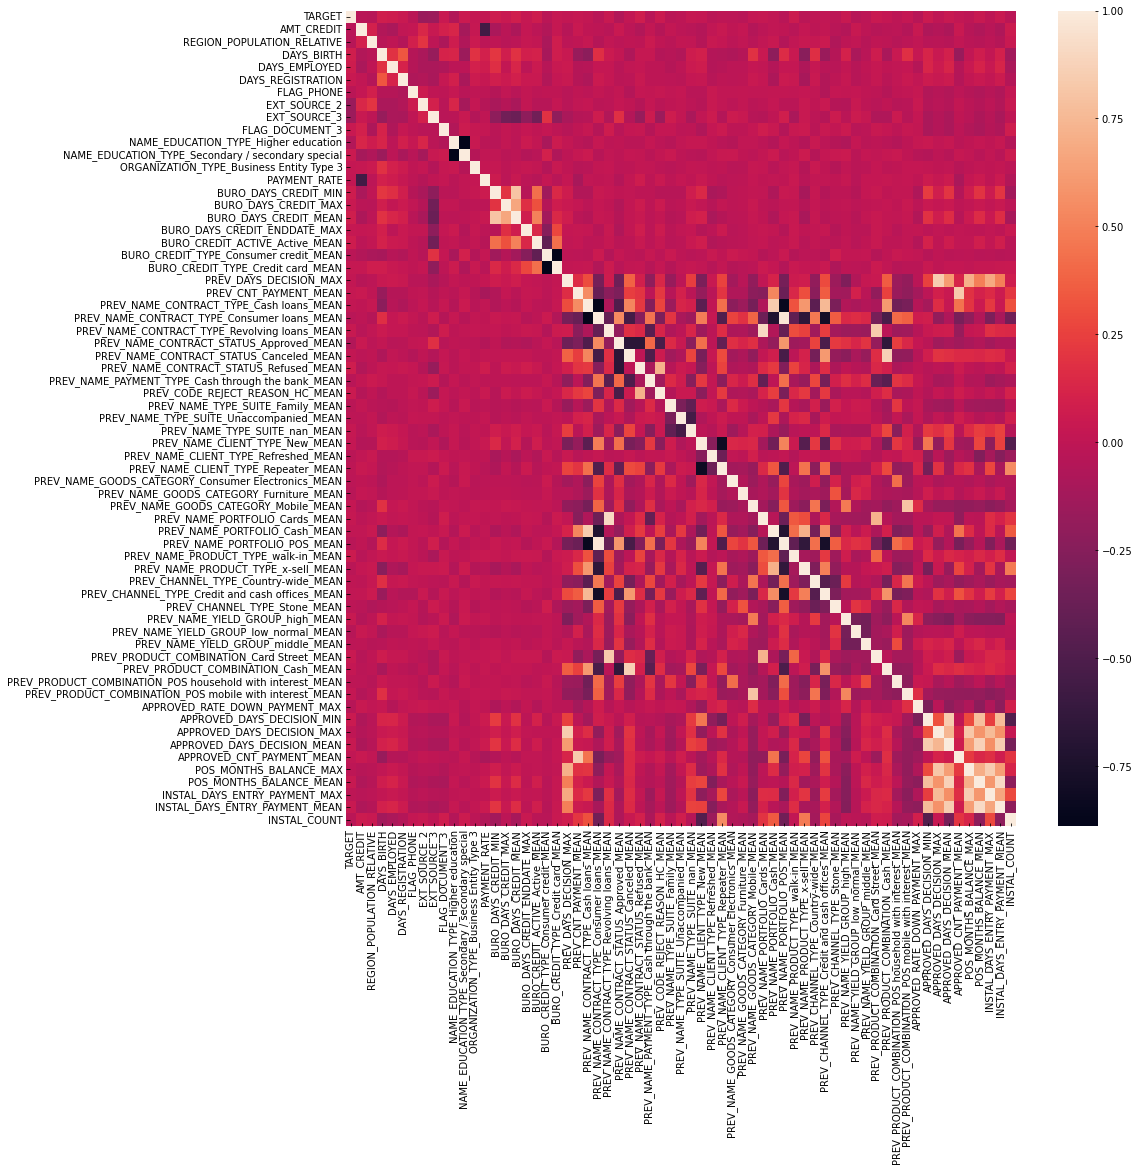

In [251]:
# heatmap correlations
plt.figure(figsize=(15, 15))
sns.heatmap(train.corr())

Certains groupes de variables sont encore corrélés : il s'agit de groupes ou il y a eu, lors du prétraitement avec le kernerl Kaggle, une agrégation des données sur le max, min et la valeur moyen. Cependant, dans un contexte de crédit, il est peut-être important de connaitre tous ces valeurs, plutôt que de connaitre, par exemple, que la moyenne. Je vais ainsi garder ces variables.

## 3.3 Valeurs aberrantes

Dans cette partie je vais examiner les valeurs aberrantes, 10 à la fois, à l'aide des boites à moustaches. 
Pour les variables dérivées des variables catégorielles je ne vais pas les remplacer (car normalement les valeurs sont toutes comprises entre 0 et 1).
Pour les autres variables, il pourrait y avoir des valeurs aberrantes mais aussi des valeurs très bas ou élevés qui ne sont pas vraiment aberrantes mais tout simplement atypiques. Le choix est le suivant : en cas de valeurs extérieurs à la boite à moustaches, je vais remplacer toutes les valeurs supérieures à la valeur du 0.9 quantile (ou inferieurs au 0.1 quantile) avec la valeur du 0.9 quantile (ou 0.1 quantile). Ceci est fait à l'aide de la fonction `replace_outliers`.

### Variables de 1 à 10

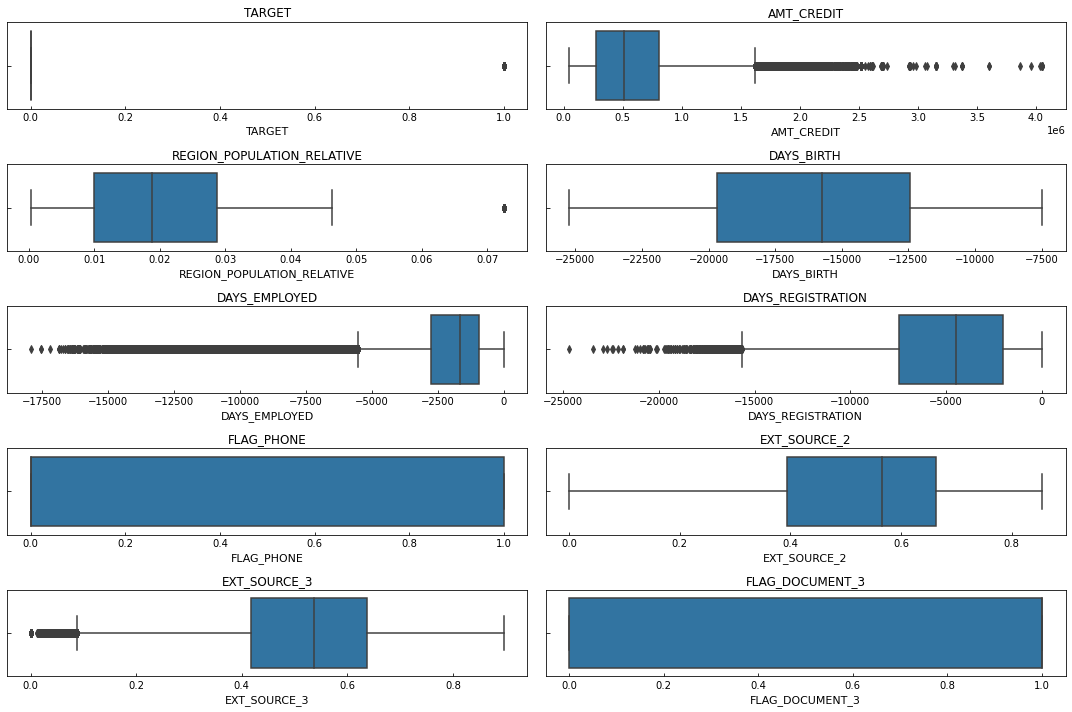

In [252]:
# boxplots
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
count = 1
for col in train.iloc[:, :10].columns:
    plt.subplot(5, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
plt.tight_layout()

In [253]:
# base statistics
train.iloc[:, :10].describe()

,TARGET,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,FLAG_PHONE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_3
count,246005.000000,2.460050e+05,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,2.460050e+05,246005.000000,246005.000000
mean,0.080730,5.992982e+05,0.020864,-16036.827833,-2251.859035,-4988.528599,0.280624,5.146460e-01,0.516182,0.710364
std,0.272421,4.028173e+05,0.013835,4359.209298,2138.230721,3521.508190,0.449305,1.908315e-01,0.174803,0.453595
min,0.000000,4.500000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,0.000000,8.173617e-08,0.000527,0.000000
25%,0.000000,2.700000e+05,0.010006,-19678.000000,-2762.000000,-7479.000000,0.000000,3.933233e-01,0.417100,0.000000
50%,0.000000,5.135310e+05,0.018850,-15748.000000,-1647.000000,-4507.000000,0.000000,5.659185e-01,0.537070,1.000000
75%,0.000000,8.086500e+05,0.028663,-12425.000000,-930.000000,-2016.000000,1.000000,6.634706e-01,0.636376,1.000000
max,1.000000,4.050000e+06,0.072508,-7489.000000,0.000000,0.000000,1.000000,8.549997e-01,0.896010,1.000000


In [254]:
# replace high values outliers
train = replace_outliers(train,[
    'AMT_CREDIT',
    'REGION_POPULATION_RELATIVE'],
                         'high')

In [255]:
# replace low values outliers
train = replace_outliers(train, [
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'EXT_SOURCE_3'],
                         'low')

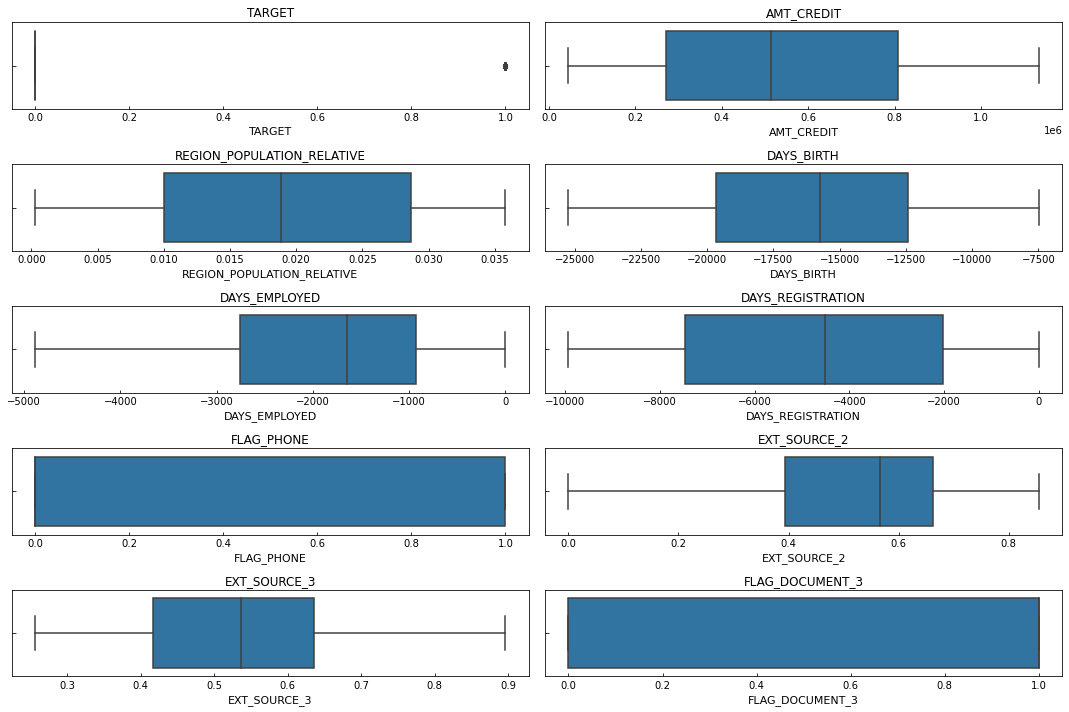

In [256]:
# checking outliers replacement
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
count = 1
for col in train.iloc[:, :10].columns:
    plt.subplot(5, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
plt.tight_layout()

### Variables de 11 à 20

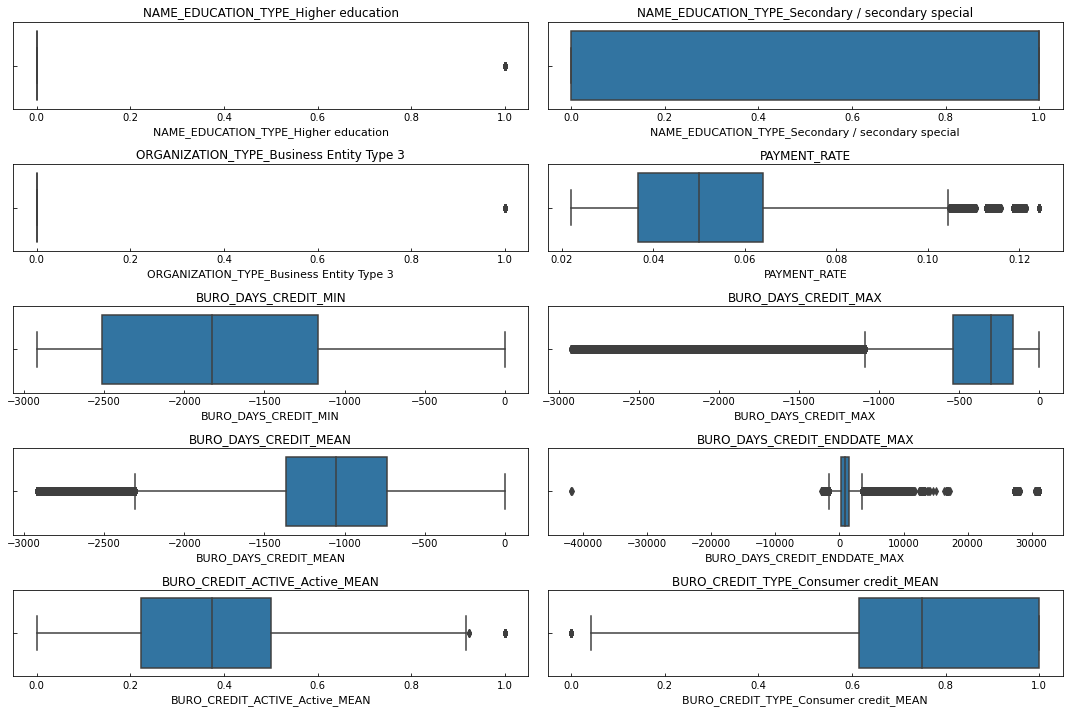

In [257]:
# boxplots
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
count = 1
for col in train.iloc[:, 10:20].columns:
    plt.subplot(5, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
plt.tight_layout()

In [258]:
# base statistics
train.iloc[:, 10:20].describe()

,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,ORGANIZATION_TYPE_Business Entity Type 3,PAYMENT_RATE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN
count,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000
mean,0.243219,0.710620,0.220857,0.053660,-1771.598122,-462.185968,-1078.495445,3905.614061,0.407440,0.724005
std,0.429027,0.453476,0.414825,0.022489,800.324850,502.189149,521.943232,8710.840346,0.285992,0.256779
min,0.000000,0.000000,0.000000,0.022073,-2922.000000,-2922.000000,-2922.000000,-41875.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.036738,-2511.000000,-536.000000,-1363.000000,253.000000,0.222222,0.615385
50%,0.000000,1.000000,0.000000,0.050000,-1827.000000,-300.000000,-1051.000000,910.000000,0.375000,0.750000
75%,0.000000,1.000000,0.000000,0.063910,-1165.000000,-167.000000,-734.750000,1561.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,0.124430,0.000000,0.000000,0.000000,31198.000000,1.000000,1.000000


In [259]:
# replace high values outliers
train = replace_outliers(train,
                         ['PAYMENT_RATE',
                          'BURO_DAYS_CREDIT_ENDDATE_MAX'],
                         'high')

In [260]:
# replace low values outliers
train = replace_outliers(train,
                         ['BURO_DAYS_CREDIT_MAX',
                          'BURO_DAYS_CREDIT_MEAN',
                          'BURO_DAYS_CREDIT_ENDDATE_MAX'],
                         'low')

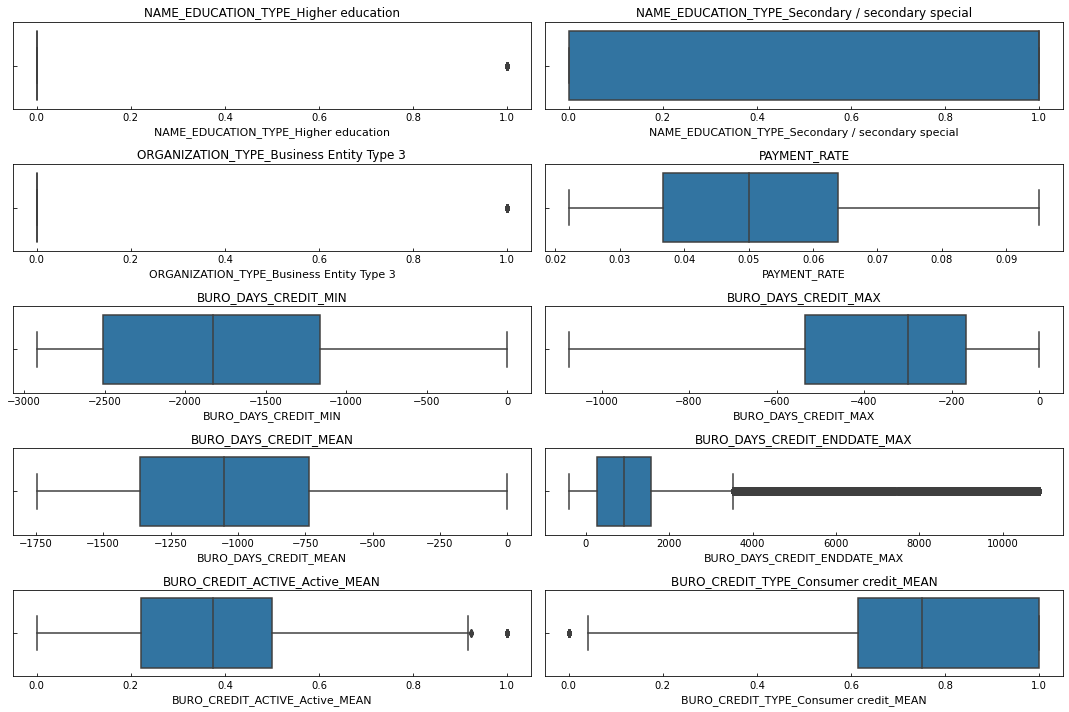

In [261]:
# cheking outliers replacement
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
count = 1
for col in train.iloc[:, 10:20].columns:
    plt.subplot(5, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
plt.tight_layout()

### Variables de 21 à 30

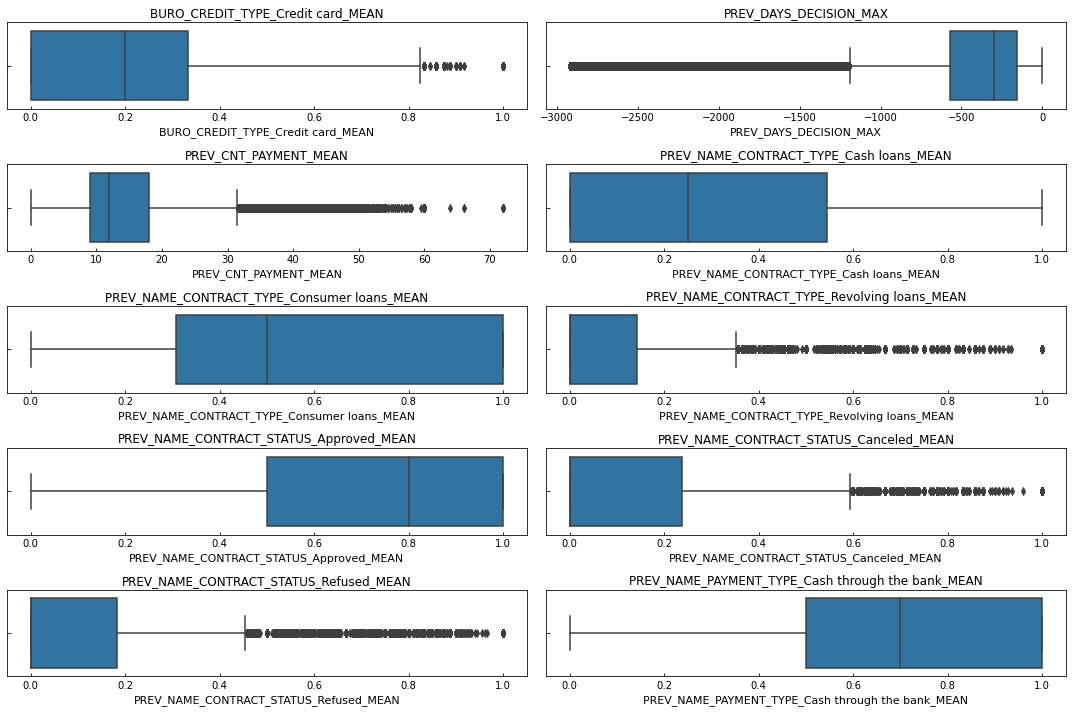

In [262]:
# boxplots
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
count = 1
for col in train.iloc[:, 20:30].columns:
    plt.subplot(5, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
plt.tight_layout()

In [263]:
# base statistics
train.iloc[:, 20:30].describe()

,BURO_CREDIT_TYPE_Credit card_MEAN,PREV_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN
count,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000
mean,0.233765,-470.675852,14.399959,0.313716,0.579798,0.093039,0.751297,0.118643,0.105125,0.681781
std,0.238413,526.987895,8.207365,0.311883,0.341581,0.166631,0.255664,0.184193,0.181131,0.293650
min,0.000000,-2922.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-569.000000,9.000000,0.000000,0.307692,0.000000,0.500000,0.000000,0.000000,0.500000
50%,0.200000,-299.000000,12.000000,0.250000,0.500000,0.000000,0.800000,0.000000,0.000000,0.700000
75%,0.333333,-154.000000,18.000000,0.545455,1.000000,0.142857,1.000000,0.238095,0.181818,1.000000
max,1.000000,-1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [264]:
# replace high values outliers
train = replace_outliers(train, 
                         ['PREV_CNT_PAYMENT_MEAN'],
                         'high')

In [265]:
# replace low values outliers
train = replace_outliers(train,
                         ['PREV_DAYS_DECISION_MAX'],
                         'low')

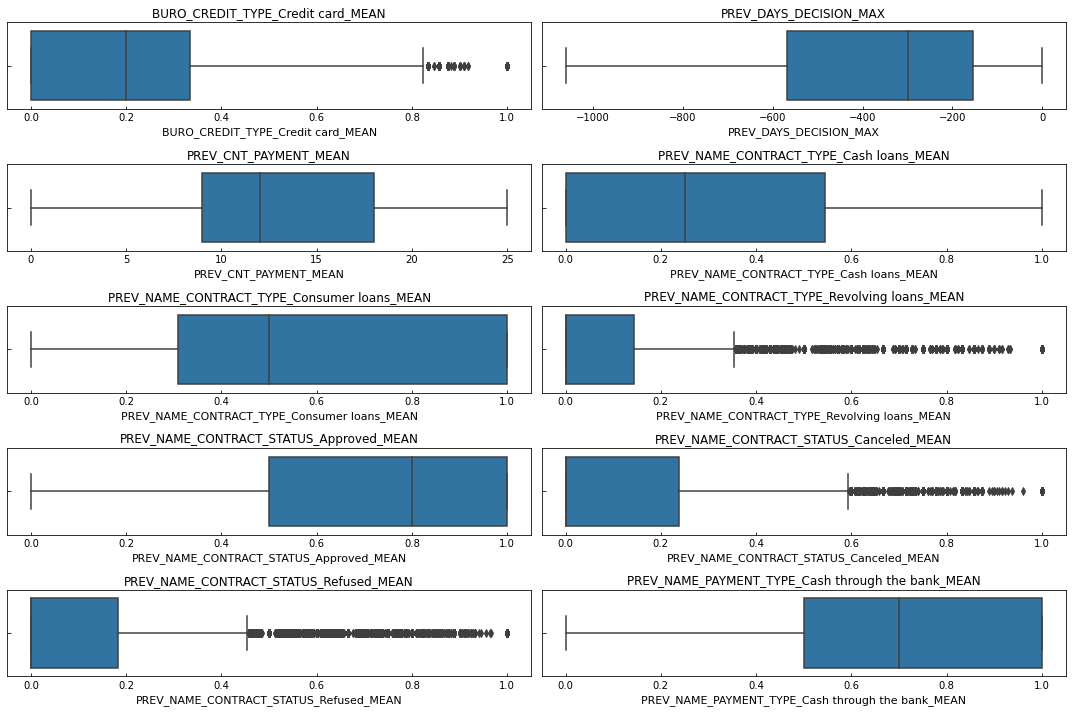

In [267]:
# checking outliers replacement
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
count = 1
for col in train.iloc[:, 20:30].columns:
    plt.subplot(5, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
plt.tight_layout()

### Variables de 31 à 40

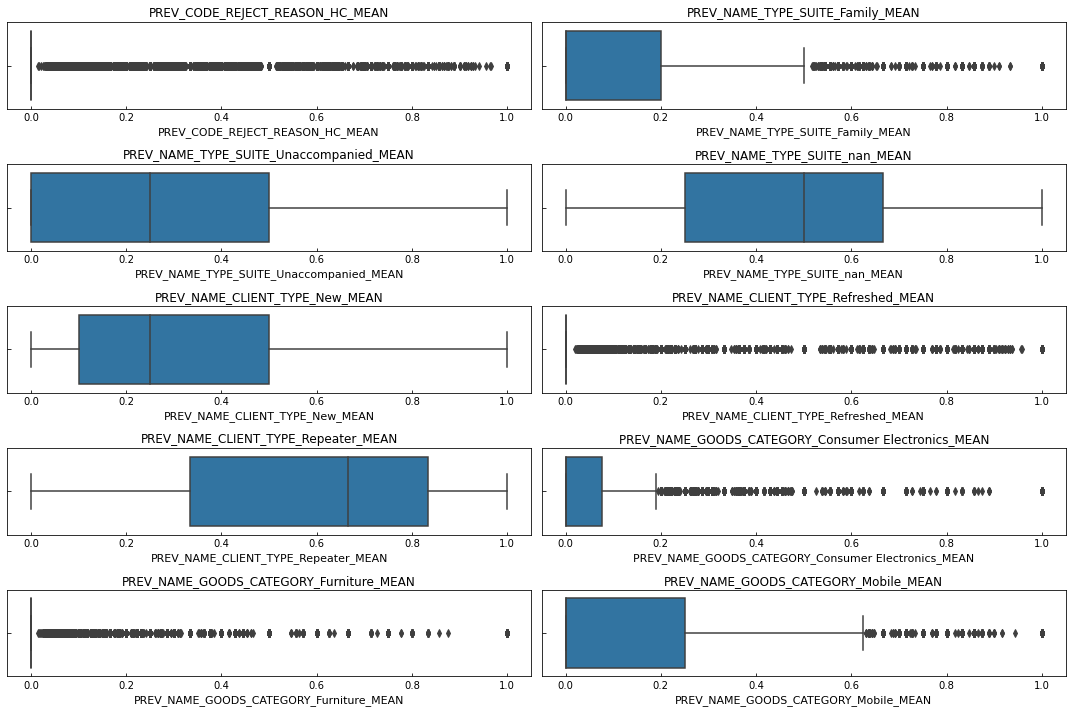

In [268]:
# boxplots
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
count = 1
for col in train.iloc[:, 30:40].columns:
    plt.subplot(5, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
plt.tight_layout()

In [269]:
# base statistics
train.iloc[:, 30:40].describe()

,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_Repeater_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Mobile_MEAN
count,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000
mean,0.056579,0.138970,0.282519,0.480445,0.344474,0.095051,0.555142,0.091934,0.043745,0.164988
std,0.130439,0.244031,0.288606,0.320630,0.333192,0.207209,0.345413,0.208476,0.155238,0.271453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.250000,0.100000,0.000000,0.333333,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.250000,0.500000,0.250000,0.000000,0.666667,0.000000,0.000000,0.000000
75%,0.000000,0.200000,0.500000,0.666667,0.500000,0.000000,0.833333,0.076923,0.000000,0.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Variables de 41 à 50

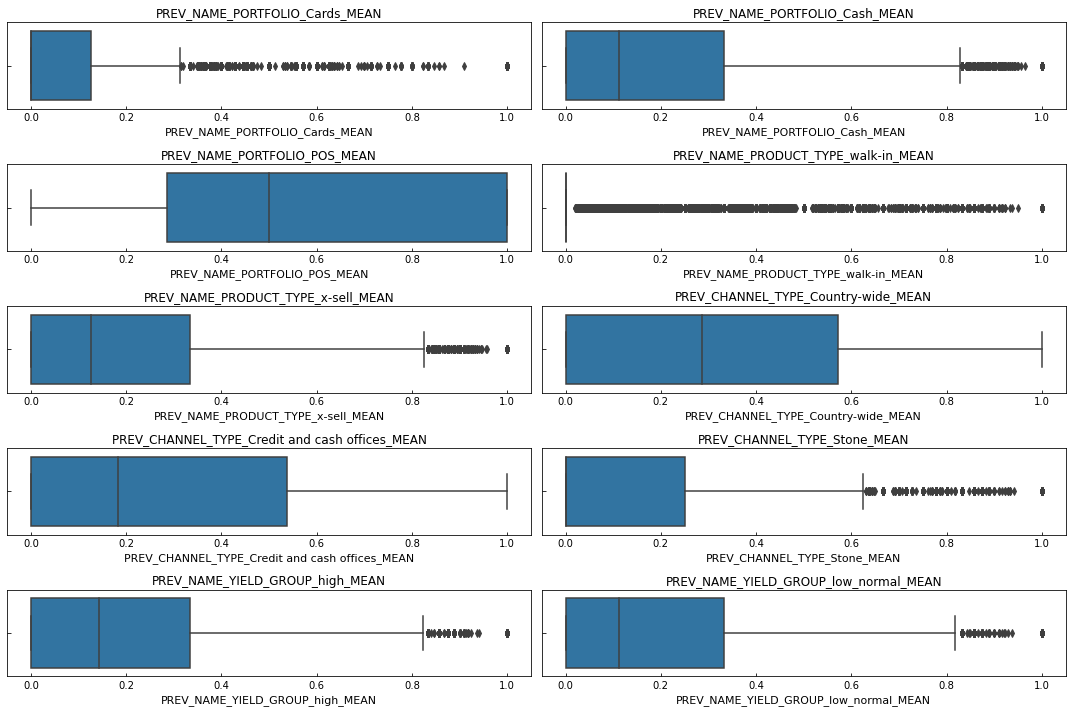

In [270]:
# boxplots
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
count = 1
for col in train.iloc[:, 40:50].columns:
    plt.subplot(5, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
plt.tight_layout()

In [271]:
# base statistics
train.iloc[:, 30:40].describe()

,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_Repeater_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Mobile_MEAN
count,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000
mean,0.056579,0.138970,0.282519,0.480445,0.344474,0.095051,0.555142,0.091934,0.043745,0.164988
std,0.130439,0.244031,0.288606,0.320630,0.333192,0.207209,0.345413,0.208476,0.155238,0.271453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.250000,0.100000,0.000000,0.333333,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.250000,0.500000,0.250000,0.000000,0.666667,0.000000,0.000000,0.000000
75%,0.000000,0.200000,0.500000,0.666667,0.500000,0.000000,0.833333,0.076923,0.000000,0.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Variables de 51 à 60

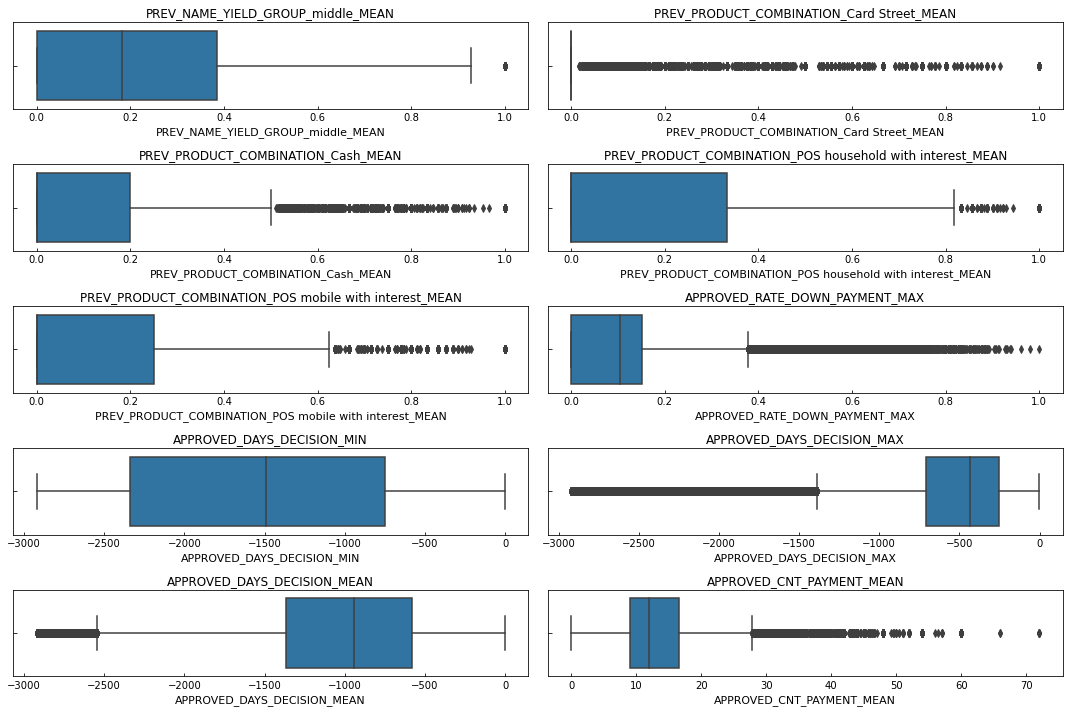

In [272]:
# boxplots
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
count = 1
for col in train.iloc[:, 50:60].columns:
    plt.subplot(5, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
plt.tight_layout()

In [273]:
# base statistics
train.iloc[:, 50:60].describe()

,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_PRODUCT_COMBINATION_Card Street_MEAN,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN
count,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000
mean,0.250655,0.056144,0.104198,0.195838,0.159504,0.122965,-1528.473564,-593.194573,-1026.767967,13.510962
std,0.286182,0.136960,0.172014,0.288937,0.268594,0.122291,838.763223,548.908749,574.001416,7.343879
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2922.000000,-2922.000000,-2922.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2337.000000,-708.000000,-1365.666667,9.000000
50%,0.181818,0.000000,0.000000,0.000000,0.000000,0.104285,-1490.000000,-434.000000,-941.000000,12.000000
75%,0.384615,0.000000,0.200000,0.333333,0.250000,0.151053,-752.000000,-254.000000,-578.500000,16.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-2.000000,-1.000000,-2.000000,72.000000


In [274]:
# replacing high values outliers
train = replace_outliers(train, [
    'APPROVED_RATE_DOWN_PAYMENT_MAX',
    'APPROVED_CNT_PAYMENT_MEAN'],
                         'high')

In [275]:
# replacing high values outliers
train = replace_outliers(train, [
    'APPROVED_DAYS_DECISION_MAX',
    'APPROVED_DAYS_DECISION_MEAN'],
                         'low')

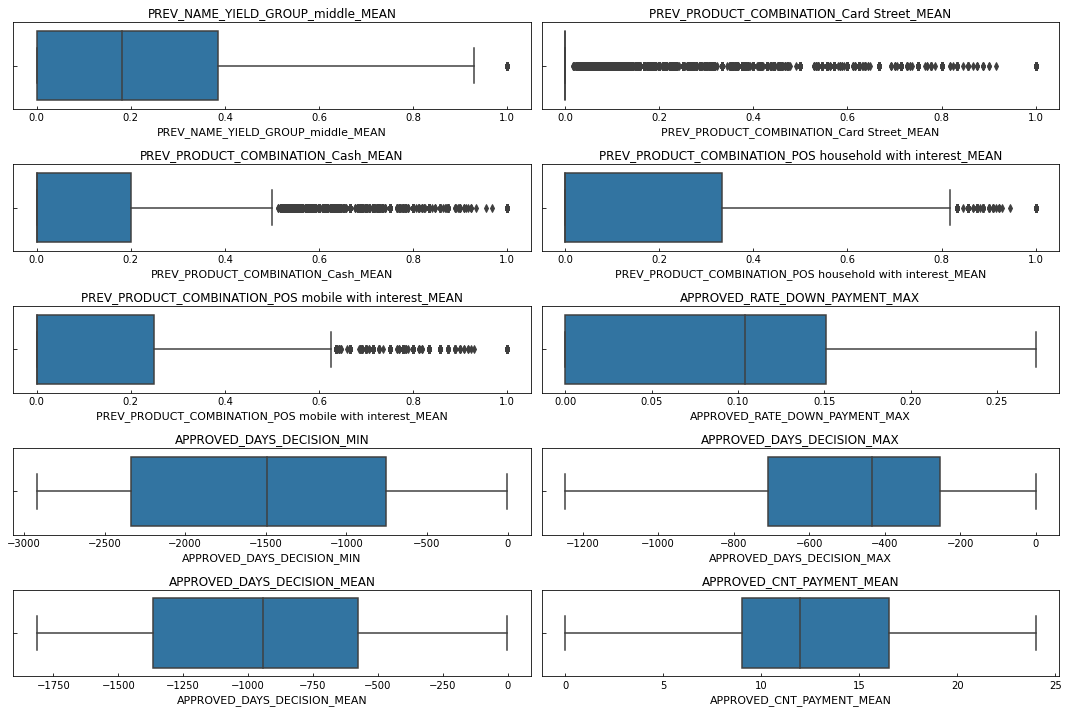

In [276]:
# boxplots
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
count = 1
for col in train.iloc[:, 50:60].columns:
    plt.subplot(5, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
plt.tight_layout()

### Variables de 61 à 65

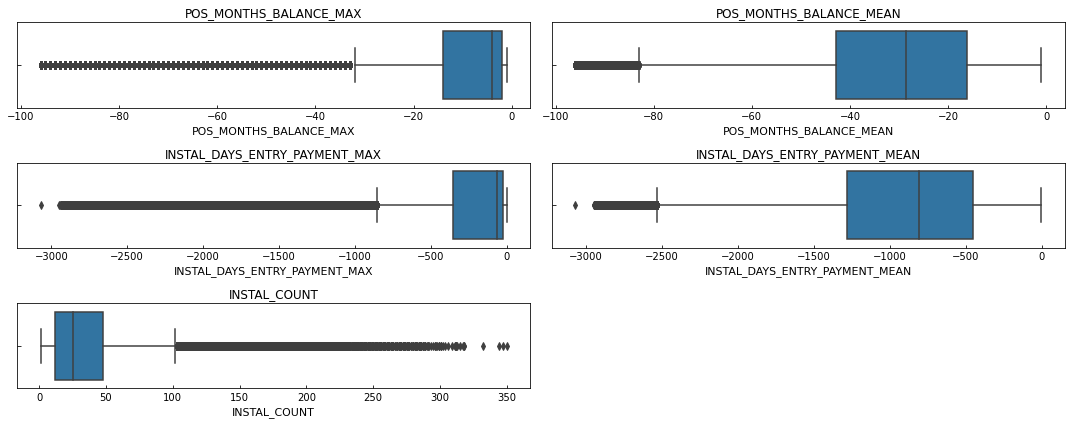

In [280]:
# boxplots
fig, ax = plt.subplots(3, 2, figsize=(15, 6))
count = 1
for col in train.iloc[:, 60:].columns:
    plt.subplot(3, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
fig.delaxes(ax[2][1])
plt.tight_layout()

In [278]:
# base statistics
train.iloc[:, 60:].describe()

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_COUNT
count,246005.000000,246005.000000,246005.000000,246005.000000,246005.000000
mean,-12.036739,-31.641353,-313.439662,-915.102240,39.037276
std,18.184360,19.516911,524.539381,581.676090,39.862833
min,-96.000000,-96.000000,-3071.000000,-3071.000000,1.000000
25%,-14.000000,-42.878788,-359.000000,-1282.703125,12.000000
50%,-4.000000,-28.607976,-65.000000,-807.764706,25.000000
75%,-2.000000,-16.113636,-27.000000,-449.636364,48.000000
max,-1.000000,-1.000000,-2.000000,-3.000000,350.000000


In [281]:
# replacing high values outliers
train = replace_outliers(train, 
                         ['INSTAL_COUNT'],
                         'high')

In [282]:
# replacing low values outliers
train = replace_outliers(train, [
    'POS_MONTHS_BALANCE_MAX',
    'POS_MONTHS_BALANCE_MEAN',
    'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
    'INSTAL_DAYS_ENTRY_PAYMENT_MEAN'],
                         'low')

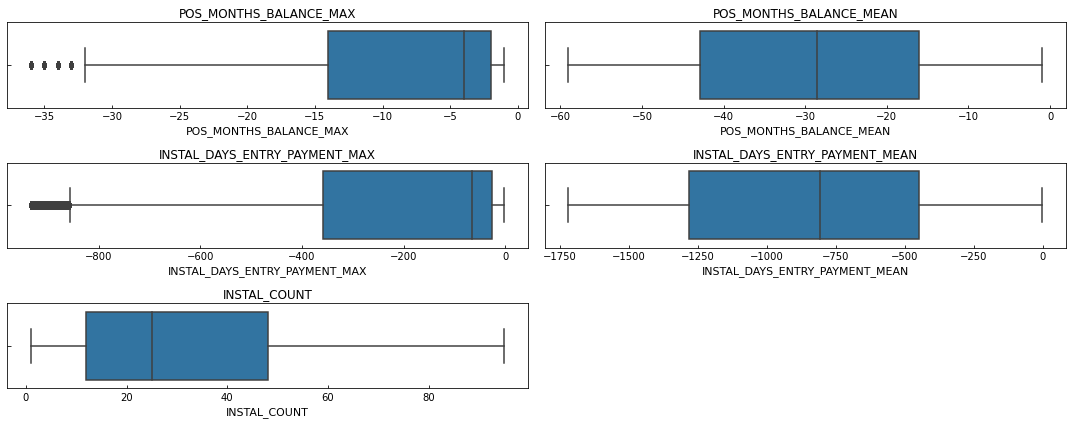

In [284]:
# checking outliers replacement
fig, ax = plt.subplots(3, 2, figsize=(15, 6))
count = 1
for col in train.iloc[:, 60:].columns:
    plt.subplot(3, 2, count)
    plt.title(col)
    sns.boxplot(data=train, x=col)
    count += 1
fig.delaxes(ax[2][1])
plt.tight_layout()

In [230]:
# saving the cleaned data
train.to_csv('../train_cleaned.csv')
test.to_csv('../test_cleaned.csv')

# 4. Conclusions

A partir du jeu de données de départ, un premier traitement et du feature engineering à été effectué à l'aide d'un kernel Kaggle. Le jeu de données après ce prétraitement comprenait 799 variables et 356251 clients. Le nombre de clients ayant remboursé le crédit est 11 fois le nombre de clients ayant fait défaut. Il faudra prendre en compte le déséquilibrage des classes lors de modélisations. 
Suite au remplacement des valeurs manquantes, des variables potentiellement intéressantes pour la modélisation ont été sélectionnées à l'aide des 3 méthodes :
- suppression des variables avec trop peu de variance
- suppression des variables en fonction de leur distribution par rapport au target (crédit remboursé/pas remboursé)
- suppression des variables très corrélées. 

Il reste encore des variables corrélés, mas dans un contexte de crédit il pourrait être utile de les garder.
Les valeurs aberrantes ont été remplacées et le jeu de données est prêt pour la modélisations.

